In [ ]:
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from models.EncoderDecoderHardMonoBig import Encoder, Decoder
import pyarrow.parquet as pq
from datasets.dataOps import create_datasets, create_dataloaders
from utils.utilities import load_checkpoint
from utils.metrics import IntegratedEvaluator

# Import IDs

In [2]:
table = pq.read_table("data/info_ts.parquet")
ids = table.to_pandas().index.to_list()

In [ ]:
data = {}
for array in ["static_data", "before_ts", "after_ts", "target_ts", "mask_target", "cat_dicos"]:
        with open(f"data/agrial_ts_wise/{array}.pkl", "rb") as f:
            data[array] = pickle.load(f)

train_dataset, val_dataset, test_dataset = create_datasets(ids,
                                                           data["static_data"],
                                                           data["before_ts"],
                                                           data["after_ts"],
                                                           data["target_ts"],
                                                           data["mask_target"],
                                                           train_size=0.6,
                                                           val_size=0.2,
                                                           raw_data_folder="data/",
                                                           means_and_stds_path="data/work_data/means_and_stds_small.pkl",
                                                           entire_bool=False)

train_loader, val_loader, test_loader = create_dataloaders(train_dataset,
                                                           val_dataset,
                                                           test_dataset,
                                                           batch_size=64)


          Train_DS = 120051 obs
          Val_DS = 40017 obs
          Test_DS = 40018 obs
          


In [ ]:
hyperparameters = {
    # Static encoder parameters
    "static_input_dim": 9,
    "list_unic_cat": [len(dico.keys()) for dico in data["cat_dicos"].values()],
    "embedding_dims": [100, 100, 100, 100],
    "hidden_dim_static_encoder": 128,

    # Dynamic encoder parameters
    "dynamic_input_dim": 7,
    "hidden_dim_dynamic_encoder": 256,
    "first_decoder_input_dim": 4,
    "gru_encoder_num_layers": 2,

    # Decoder parameters
    "gru_input_dim": 4,
    "gru_hidden_dim": 256 + 128,  # hidden_dim_dynamic_encoder + hidden_dim_static_encoder
    "stepwise_input_dim": 7,
    "main_hidden_dim": 128,
    "mask_hidden_dim": 128,
    "output_dim": 4,
    "monotonic_indices": [0, 2, 3],  # Example indices for monotonic MLPs
    "gru_decoder_num_layers": 2,

    # Training cycle parameters
    "batch_size": 64,
    "teacher_forcing_ratio": 0.7,
    "max_norm": 1.0,
    "learning_rate": 1e-4,
    "num_epochs": 50,
    "monotonicity_bool": False
    }

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)

encoder = Encoder(static_input_dim=hyperparameters["static_input_dim"],
                  static_hidden_dim=hyperparameters["hidden_dim_static_encoder"],
                  list_unic_cat=hyperparameters["list_unic_cat"],
                  embedding_dims=hyperparameters["embedding_dims"],
                  dynamic_input_dim=hyperparameters["dynamic_input_dim"],
                  dynamic_hidden_dim=hyperparameters["hidden_dim_dynamic_encoder"],
                  first_decoder_input_dim=hyperparameters["first_decoder_input_dim"],
                  gru_num_layers=hyperparameters["gru_encoder_num_layers"]).to(device)

decoder = Decoder(gru_input_dim=hyperparameters["gru_input_dim"],
                  gru_hidden_dim=hyperparameters["gru_hidden_dim"],
                  stepwise_input_dim=hyperparameters["stepwise_input_dim"],
                  main_hidden_dim=hyperparameters["main_hidden_dim"],
                  output_dim=hyperparameters["output_dim"],
                  monotonic_indices=hyperparameters["monotonic_indices"],
                  num_layers=hyperparameters["gru_decoder_num_layers"]).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


Using device: cuda


In [ ]:
checkpoint = torch.load("checkpoints/02_non_physical_HardWiredBIG_50_eps/best_model.pth")
load_checkpoint(checkpoint,
                encoder,
                decoder,
                optimizer)

=== Loading checkpoint ===


In [7]:
with open("data/agrial_ts_wise/means_and_stds.pkl", "rb") as f:
    means_and_stds = pickle.load(f)


In [8]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    batch_hat_target = []
    batch_hat_mask = []
    batch_target = []
    batch_mask = []
    ids = []
    for batch in test_loader:
        ids.append(batch["id"])
        static_data_cat = batch["static_data_cat"].to(device)
        static_data_num = batch["static_data_num"].to(device)
        before_ts = batch["before_ts"].to(device)
        after_ts = batch["after_ts"].to(device)
        target_ts = batch["target_ts"].to(device)
        mask_target = batch["mask_target"].to(device)

        latent, x_t = encoder(static_data_num, static_data_cat, before_ts)
        h_t = latent
        generated_ts = [] 
        for t in range(after_ts.shape[1]):
            output, h_t, h_output = decoder(x_t.unsqueeze(1), h_t, after_ts[:, t, :])
            x_t = output
            generated_ts.append(output)

        batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        # batch_hat_target.append(torch.stack(generated_ts, dim=1))
        # batch_target.append(target_ts)
        batch_mask.append(mask_target)
    # all_ts = torch.stack(batch_ts, dim=1)
    # all_mask = torch.stack(batch_mask, dim=1)

/tmp/ipykernel_2330625/3389845642.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
/tmp/ipykernel_2330625/3389845642.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])


In [9]:
print(batch_target[0].shape, batch_hat_target[0].shape)

torch.Size([128, 200, 4]) torch.Size([128, 200, 4])


In [10]:
print(len(batch_mask))

313


In [11]:
batch_hat_target[0][0].shape

torch.Size([200, 4])

0000ea6a-b8dd-4e3d-9a68-2f03e3e3351a


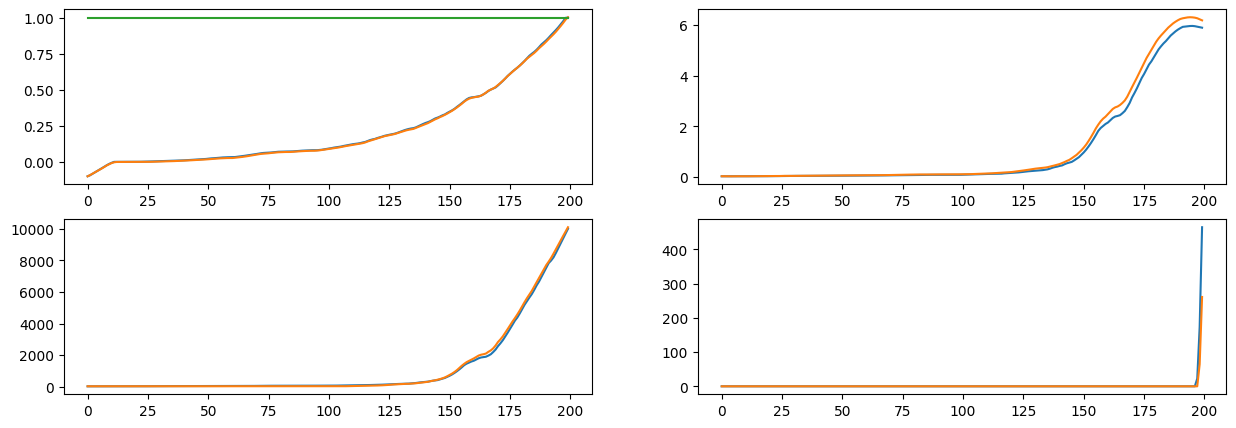

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
i = 4
print(ids[0][i])
sns.lineplot(batch_target[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_hat_target[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_mask[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_target[0][i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(batch_hat_target[0][i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(batch_target[0][i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(batch_hat_target[0][i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(batch_target[0][i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(batch_hat_target[0][i][:,3].to("cpu").numpy(), ax=ax[1, 1])
plt.show()

In [13]:
concat_batch_hat_target = torch.cat(batch_hat_target, dim=0).to("cpu")
concat_batch_target = torch.cat(batch_target, dim=0).to("cpu")
concat_real_mask = torch.cat(batch_mask, dim=0).to("cpu")

In [14]:
concat_real_mask.squeeze(2).numpy()

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int8)

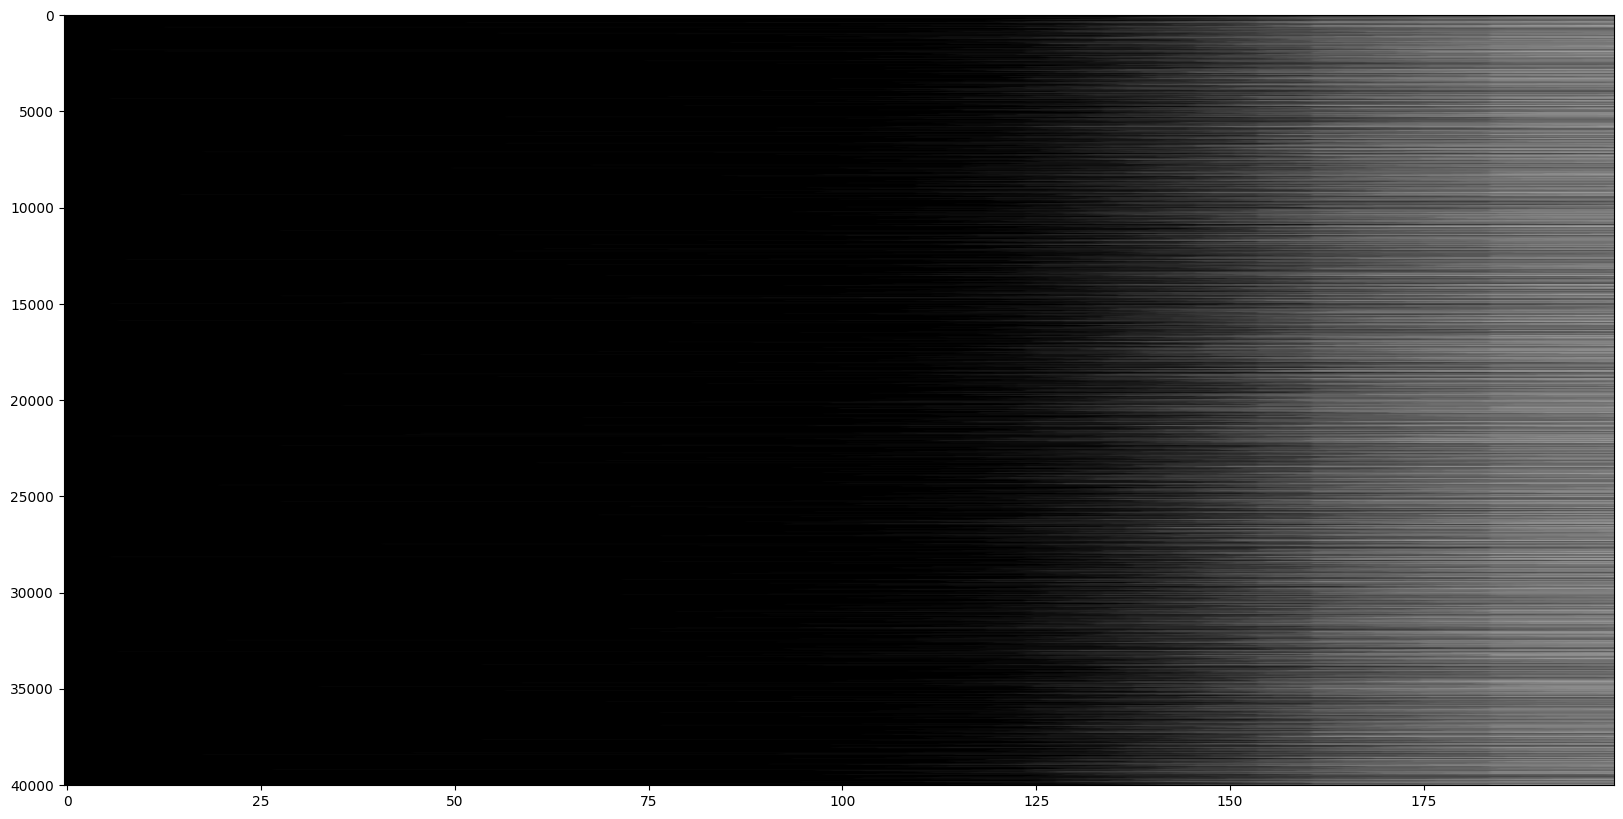

In [15]:
# Do a graphic of concat_real_mask when one line is an observation, then 1 is black, 0 is white
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(concat_real_mask.squeeze(2).numpy(), aspect="auto", cmap="binary")
plt.show()

In [16]:
# find the maximum value index

cosa = abs((concat_batch_hat_target*concat_real_mask)-(concat_batch_target*concat_real_mask))

x_flat = cosa.view(-1)

# Get index of max value
max_index = x_flat.argmax()

# Convert flat index back to multi-dimensional index
max_position = torch.unravel_index(max_index, cosa.shape)

In [17]:
x_flat[max_index].item()

20183.79269948723

In [18]:
max_position

(tensor(14477), tensor(184), tensor(2))

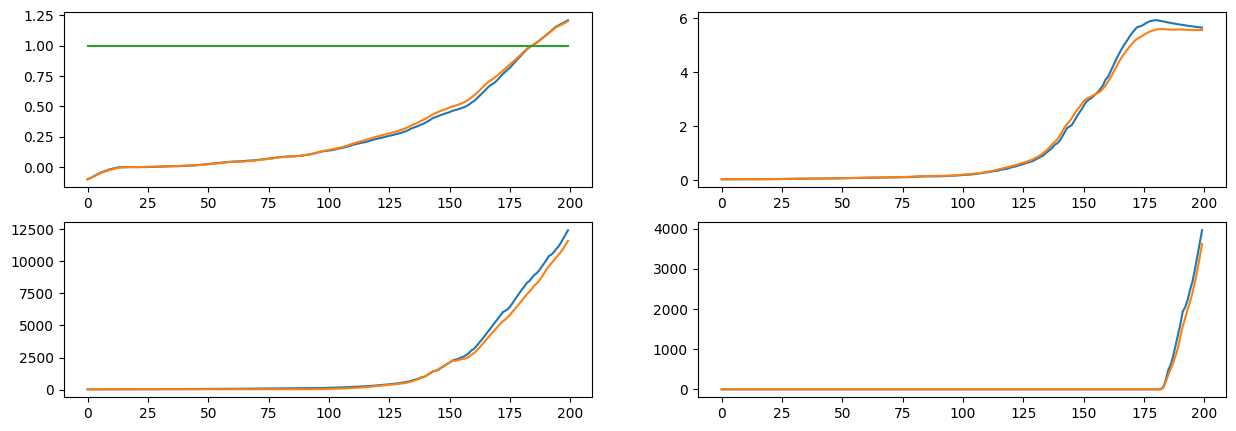

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
i = 13157
sns.lineplot(concat_batch_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_hat_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_real_mask[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_hat_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_hat_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_hat_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
plt.show()

In [20]:
concat_batch_target.shape

torch.Size([40018, 200, 4])

In [21]:
evaluator = IntegratedEvaluator(y_true=concat_batch_target.numpy(),
                                y_pred=concat_batch_hat_target.numpy(),
                                mask=concat_real_mask.squeeze(-1).numpy()
                                )

In [22]:
print(evaluator.to_dataframe())

                 MAE         RMSE        R2      MASE  MonoViolation
Variable                                                            
Var_0       0.022204     0.047609  0.994423  0.046356            0.0
Var_1       0.312837     0.667328  0.905381  0.167998            0.5
Var_2     741.072868  1769.013583  0.931169  0.145676            0.0
Var_3     373.552073  1155.220555  0.826630  0.239045            0.0


In [23]:
evaluator.summary()

{'MAE': 278.73999539566654,
 'RMSE': 731.2372688796773,
 'R2': 0.9144007098020058,
 'MASE': 0.14976854432919792,
 'MonoViolation': 0.125}

In [24]:
evaluator.evaluate_last_timestep()

MAE         RMSE        R2
Variable                                    
Var_0        0.041849     0.076920  0.972182
Var_1        0.376419     0.613629  0.943395
Var_2     1048.370729  1580.566167  0.871044
Var_3      553.931023  1125.267354  0.874103